In [251]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os



In [252]:
#Read the data
data_df = pd.read_excel("Telco_customer_churn.csv.xlsx")

In [253]:
#Check the data
print("data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

data -  rows: 7043  columns: 33


In [254]:
#Glimpse the data
#We start by looking to the data features (first 5 rows).
data_df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [255]:
#Let's look into more details to the data.

data_df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [256]:
#convert



from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
data_df=MultiColumnLabelEncoder(columns = ['Gender','Senior Citizen','Partner','Dependents','Phone Service','Paperless Billing','Phone Service']).fit_transform(data_df)

In [257]:
#encodage des données
data_df = pd.get_dummies(data_df, columns=["Multiple Lines","Internet Service","Online Security","Online Backup","Device Protection"
                      ,"Tech Support","Streaming TV","Streaming Movies","Contract","Payment Method"], drop_first=True)

In [258]:
#Check missing data
#Let's check if there is any missing data.
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Churn Reason,Churn Score,Churn Value,Churn Label,Total Charges,Monthly Charges,Paperless Billing,Phone Service,Tenure Months,Dependents,Partner,Payment Method_Mailed check,Gender,Longitude,Latitude,Lat Long,Zip Code,City,State,Country,Count,Senior Citizen,CLTV,Payment Method_Electronic check,Tech Support_No internet service,Payment Method_Credit card (automatic),Contract_Two year,Contract_One year,Streaming Movies_Yes,Streaming Movies_No internet service,Streaming TV_Yes,Streaming TV_No internet service,Tech Support_Yes,Device Protection_Yes,Multiple Lines_No phone service,Device Protection_No internet service,Online Backup_Yes,Online Backup_No internet service,Online Security_Yes,Online Security_No internet service,Internet Service_No,Internet Service_Fiber optic,Multiple Lines_Yes,CustomerID
Total,5174.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,73.463013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [281]:
# supprimer les colonne customerID et Churn Reason 
data_df = data_df.drop(['CustomerID','Churn Reason','Count','Country','State','City','Churn Label'], axis=1)

In [282]:
#Data unbalance
#Let's check data unbalance with respect with target value, i.e. Class.temp = data_df["Class"].value_counts()
temp = data_df["Churn Value"].value_counts()
df = pd.DataFrame({'Churn Value': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Churn Value'],y = df['values'],
    name="Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Churn Value', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Churn Value')

In [283]:
#Data exploration
#Transactions in time
class_0 = data_df.loc[data_df['Churn Value'] == 0]["Tenure Months"]
class_1 = data_df.loc[data_df['Churn Value'] == 1]["Tenure Months"]
#plt.figure(figsize = (14,4))
#plt.title('Credit Card Transactions Time Density Plot')
#sns.set_color_codes("pastel")
#sns.distplot(class_0,kde=True,bins=480)
#sns.distplot(class_1,kde=True,bins=480)
#plt.show()
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Transactions by T Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

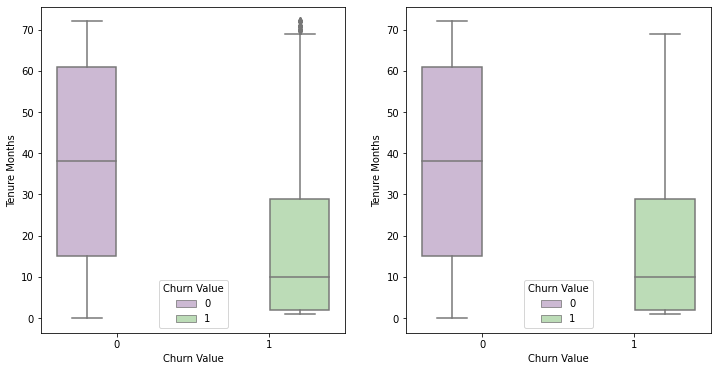

In [284]:
#Transactions amount
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Churn Value", y="Tenure Months", hue="Churn Value",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Churn Value", y="Tenure Months", hue="Churn Value",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [285]:
tmp = data_df[['Tenure Months','Churn Value']].copy()
class_0 = tmp.loc[tmp['Churn Value'] == 0]['Tenure Months']
class_1 = tmp.loc[tmp['Churn Value'] == 1]['Tenure Months']
class_0.describe()

count    5174.000000
mean       37.569965
std        24.113777
min         0.000000
25%        15.000000
50%        38.000000
75%        61.000000
max        72.000000
Name: Tenure Months, dtype: float64

In [286]:
class_1.describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: Tenure Months, dtype: float64

In [287]:
fraud = data_df.loc[data_df['Churn Value'] == 1]

trace = go.Scatter(
    x = fraud['Tenure Months'],y = fraud['Total Charges'],
    name="Total Charges",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Total Charges'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Total Charges of fraudulent transactions',
          xaxis = dict(title = 'Tenure Months [s]', showticklabels=True), 
          yaxis = dict(title = 'Total Charges'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-Total Charges')

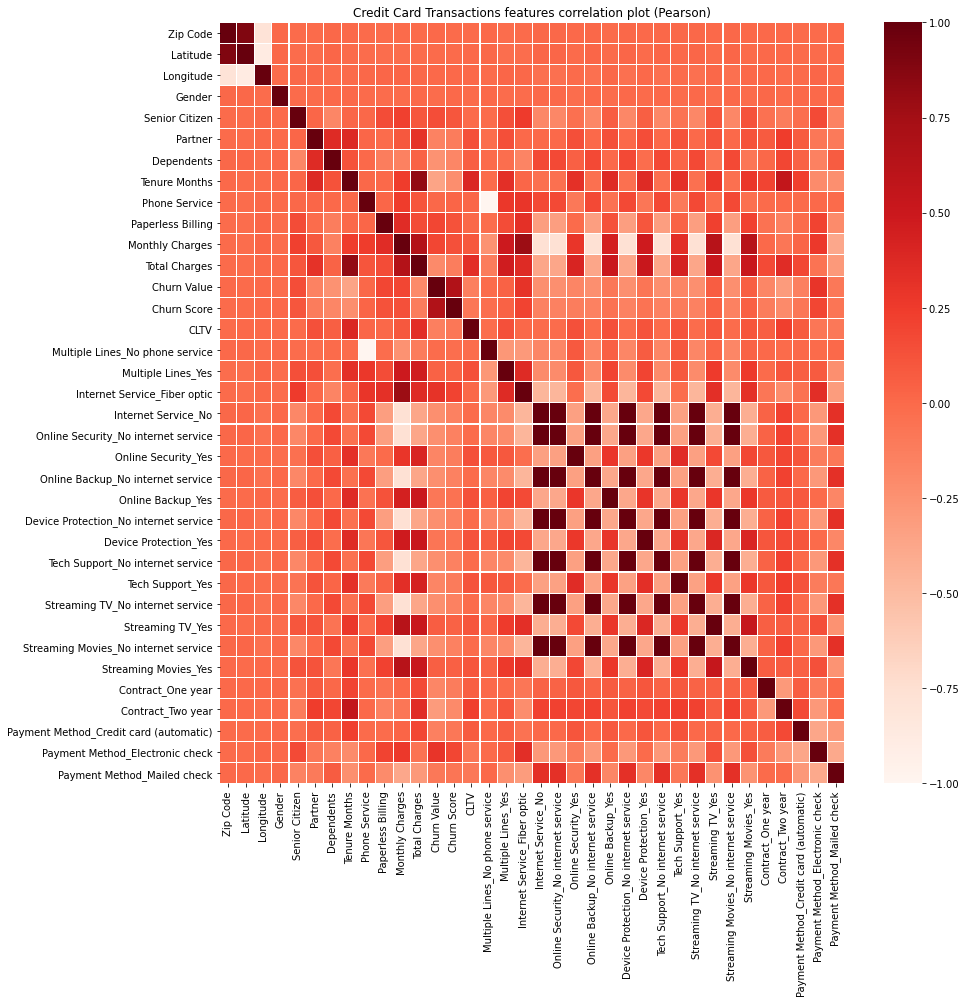

In [288]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

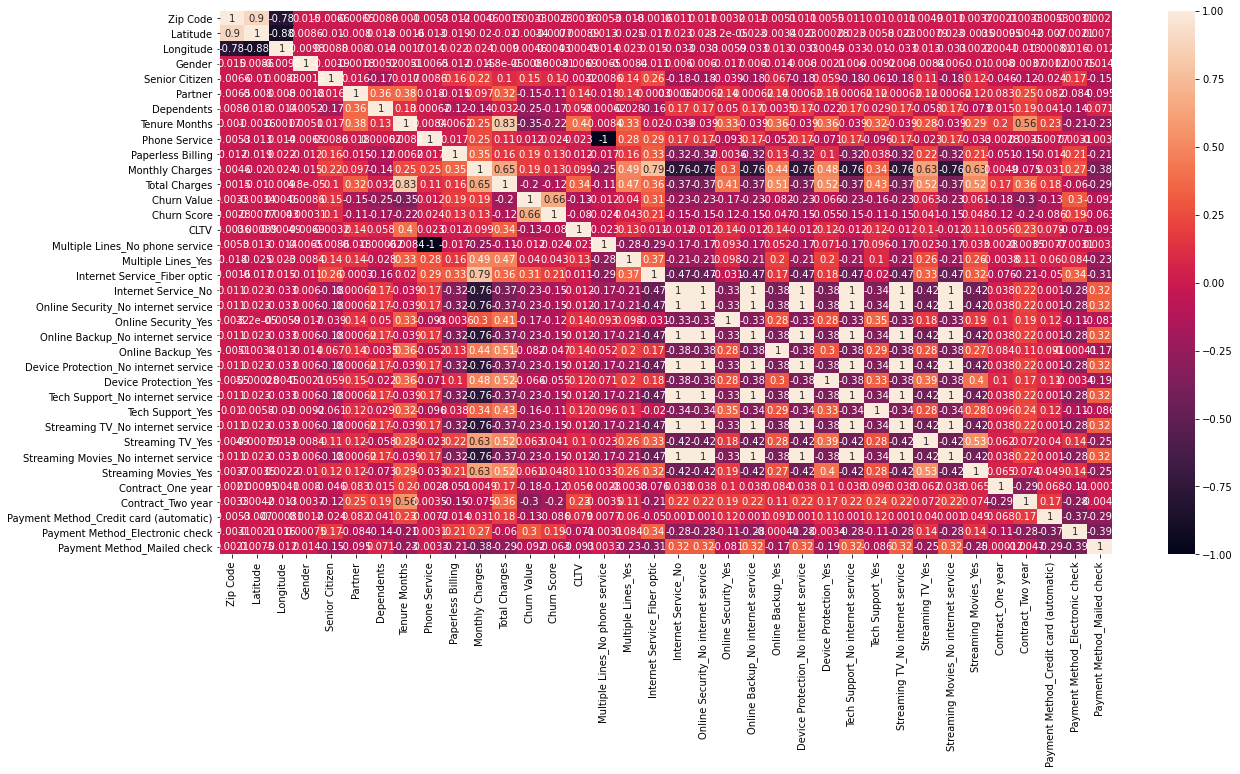

In [403]:
#correlations entre les différentes colonnes
def show_correlations(dataframe, show_chart = True):
    fig = plt.figure(figsize = (20,10))
    corr = dataframe.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

correlation_df = show_correlations(data_df,show_chart=True)

In [414]:
#corrélation avec la variable churn
show_correlations(data_df, show_chart=False)["Churn Value"].sort_values(ascending=False)



Churn Value                               1.000000
Churn Score                               0.664897
Internet Service_Fiber optic              0.308020
Payment Method_Electronic check           0.301919
Monthly Charges                           0.193356
Paperless Billing                         0.191825
Senior Citizen                            0.150889
Streaming TV_Yes                          0.063228
Streaming Movies_Yes                      0.061382
Multiple Lines_Yes                        0.040102
Phone Service                             0.011942
Longitude                                 0.004594
Zip Code                                  0.003346
Latitude                                 -0.003384
Gender                                   -0.008612
Multiple Lines_No phone service          -0.011942
Device Protection_Yes                    -0.066160
Online Backup_Yes                        -0.082255
Payment Method_Mailed check              -0.091683
CLTV                           

<Figure size 1440x720 with 0 Axes>

In [289]:
#object to float totalcharges
data_df['Total Charges'] = data_df['Total Charges'].replace(r'\s+', np.nan, regex=True)
data_df['Total Charges'] = pd.to_numeric(data_df['Total Charges'])

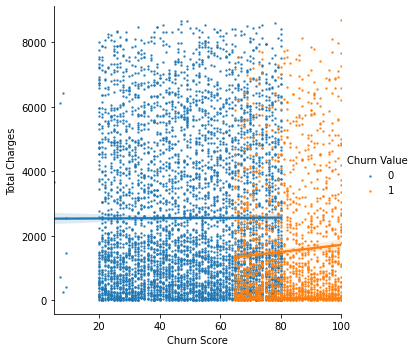

In [290]:
s = sns.lmplot(x='Churn Score', y='Total Charges',data=data_df, hue='Churn Value', fit_reg=True,scatter_kws={'s':2})
plt.show()

In [422]:
data_df1=data_df.drop(['Gender','Longitude','Latitude','Lat Long'],axis=1)
y= data_df1['Churn Value']
X= data_df1[['Churn Score',                               
'Internet Service_Fiber optic',             
'Payment Method_Electronic check',           
'Monthly Charges',                          
'Paperless Billing',                         
'Senior Citizen',                            
'Streaming TV_Yes',                          
'Streaming Movies_Yes',                      
'Multiple Lines_Yes',                        
'Phone Service']]


In [423]:
Y.dtypes

CustomerID                                 object
Count                                       int64
Country                                    object
State                                      object
City                                       object
Zip Code                                    int64
Lat Long                                   object
Latitude                                  float64
Longitude                                 float64
Gender                                      int32
Senior Citizen                              int32
Partner                                     int32
Dependents                                  int32
Tenure Months                               int64
Phone Service                               int64
Paperless Billing                           int32
Monthly Charges                           float64
Total Charges                             float64
Churn Label                                object
Churn Score                                 int64


In [424]:
X.shape

(7043, 10)

In [425]:
Y.shape

(7043, 43)

In [426]:
#### Diviser l'ensemble des observations X et l'ensemble de classes y, chacun en deux sous-ensembles :

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=3)# random_state=some_number pour garantir que votre split sera toujours le même

In [427]:
#### Importer le modèle __`DecisionTreeClassifier`__ à partir du module __`tree`__ du module __`sklearn`__.
from sklearn.tree import DecisionTreeClassifier

In [428]:
#### Créer une instance   __`dt`__  de la classe  __`DecisionTreeClassifier`__ en fixant à __zéro__  __`random_state`__. Garder l'indice de Gini comme __`criterion`__ par defaut. 
dt = DecisionTreeClassifier(random_state=0)

In [429]:
y_train = np.nan_to_num(y_train)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

In [430]:
#### Entrainer le modèle __`dt`__ sur les sous-ensembles d'apprentissage (observations et classes) 
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [431]:
#Calculer les scores d'apprentissage et de test relatifs au modèle dt
print('Le train score est :', dt.score(X_train, y_train))
print('Le test score est :', dt.score(X_test, y_test))

Le train score est : 0.9993914807302231
Le test score est : 0.8868906767628963


In [432]:
from sklearn.metrics import confusion_matrix
y_pred = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[1415  136]
 [ 103  459]]


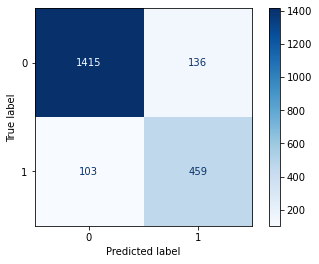

In [433]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [434]:
from sklearn.metrics import classification_report
y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred, digits=8,  ))

              precision    recall  f1-score   support

           0  0.93214756 0.91231464 0.92212447      1551
           1  0.77142857 0.81672598 0.79343129       562

    accuracy                      0.88689068      2113
   macro avg  0.85178807 0.86452031 0.85777788      2113
weighted avg  0.88940072 0.88689068 0.88789562      2113



In [435]:
dt.feature_importances_

array([0.69346002, 0.04378972, 0.01641168, 0.17998974, 0.01205766,
       0.01412079, 0.01287518, 0.0078409 , 0.01588494, 0.00356937])

In [436]:

X.keys()

Index(['Churn Score', 'Internet Service_Fiber optic',
       'Payment Method_Electronic check', 'Monthly Charges',
       'Paperless Billing', 'Senior Citizen', 'Streaming TV_Yes',
       'Streaming Movies_Yes', 'Multiple Lines_Yes', 'Phone Service'],
      dtype='object')

In [437]:
names=['Churn Score',                               
'Internet Service_Fiber optic',             
'Payment Method_Electronic check',           
'Monthly Charges',                          
'Paperless Billing',                         
'Senior Citizen',                            
'Streaming TV_Yes',                          
'Streaming Movies_Yes',                      
'Multiple Lines_Yes',                        
'Phone Service']


In [438]:
for var, importance in zip(names, dt.feature_importances_):
    if importance != 0:
        print(var, importance)

Churn Score 0.6934600214503648
Internet Service_Fiber optic 0.04378971596221736
Payment Method_Electronic check 0.016411684847932657
Monthly Charges 0.1799897413160003
Paperless Billing 0.012057656033585554
Senior Citizen 0.014120793831239814
Streaming TV_Yes 0.012875177642626464
Streaming Movies_Yes 0.007840901584093406
Multiple Lines_Yes 0.01588494107867192
Phone Service 0.0035693662532677146


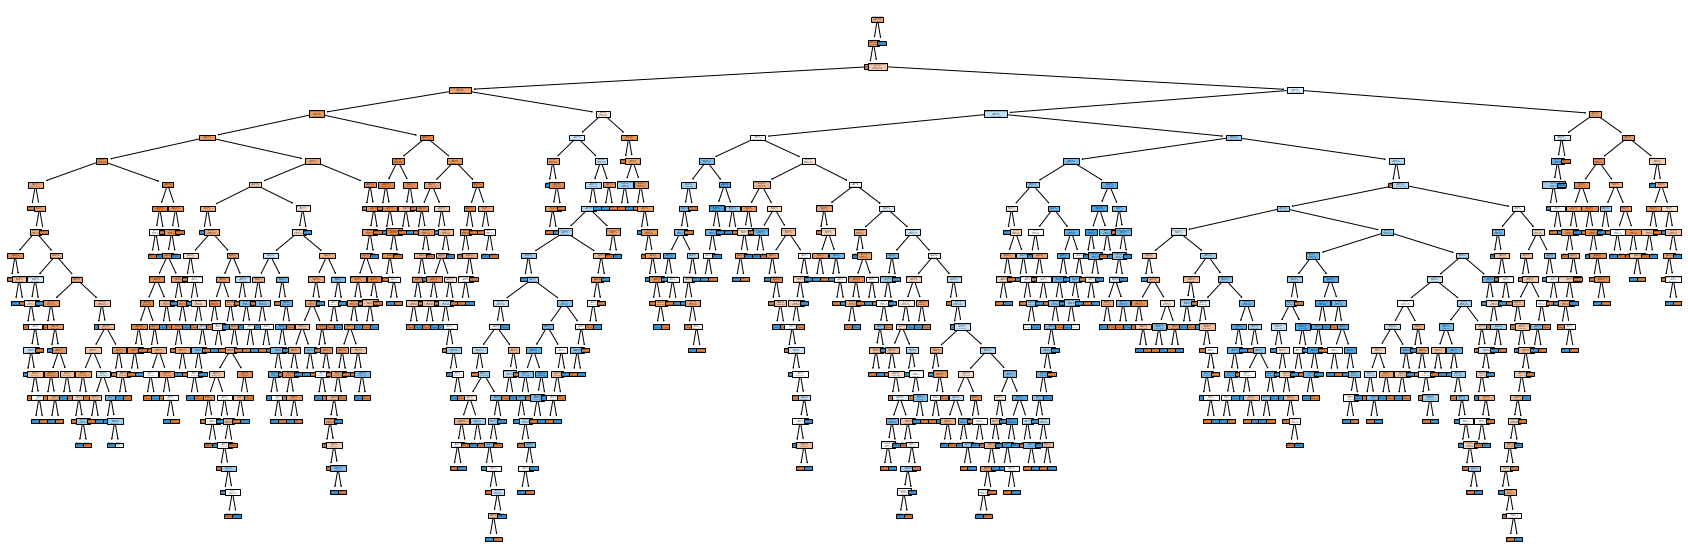

In [439]:
#Exécuter le code ci-dessous pour afficher l'arbre de décision
from sklearn.tree import plot_tree
plt.figure(figsize=(30,10))
plot_tree(dt, feature_names= names, filled=True)
plt.show()


In [441]:
#Exécuter le code ci-dessous pour afficher l'arbre sous forme de régles de décision
from sklearn.tree import export_text
print(export_text(dt, feature_names=names))


|--- Churn Score <= 80.50
|   |--- Churn Score <= 64.50
|   |   |--- class: 0
|   |--- Churn Score >  64.50
|   |   |--- Internet Service_Fiber optic <= 0.50
|   |   |   |--- Payment Method_Electronic check <= 0.50
|   |   |   |   |--- Multiple Lines_Yes <= 0.50
|   |   |   |   |   |--- Monthly Charges <= 24.43
|   |   |   |   |   |   |--- Churn Score <= 70.50
|   |   |   |   |   |   |   |--- Monthly Charges <= 19.18
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Monthly Charges >  19.18
|   |   |   |   |   |   |   |   |--- Senior Citizen <= 0.50
|   |   |   |   |   |   |   |   |   |--- Churn Score <= 65.50
|   |   |   |   |   |   |   |   |   |   |--- Monthly Charges <= 20.28
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- Monthly Charges >  20.28
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- Churn Score >  65.50
|   |   |   |   

In [455]:
param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': np.arange(1,10)}

In [456]:
#Charger la méthode GridSearchCV
from sklearn.model_selection import GridSearchCV

In [457]:
#Créer une instance de recherche par grille appliquée sur l'algorithme de classification par arbre de décision. La recherche doit tester toutes les combinaisons des valeurs des hyperparamètres
grid = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid=param_grid, cv=5)


In [458]:
#Entrainer l'instance de modèle créé sur les sous-ensembles de données approprié.
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [459]:
#Afficher les meilleures valeurs des hyperparamètres réglés
grid.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [460]:
#Créer une instance final_model de l'algorithme de classification par arbres de décision en utilisant les meilleurs hyperparamètres
final_model = DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth=6)

In [461]:
#Entrainer final_model sur le sous-ensemble de données approprié.
final_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

In [462]:
#Evaluer la performance de final_model sur le sous-ensemble de données approprié
print( 'le train_score=',final_model.score(X_train, y_train))
print( 'le test_score=',final_model.score(X_test, y_test))


le train_score= 0.918052738336714
le test_score= 0.9115002366303834


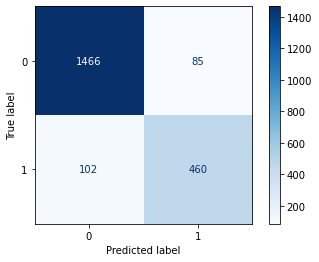

In [463]:
#tracer la matrice de confusion de final_model
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(final_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [464]:
#Afficher le classification_report de final_model
from sklearn.metrics import classification_report
y_pred = final_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=8 ))

              precision    recall  f1-score   support

           0  0.93494898 0.94519665 0.94004489      1551
           1  0.84403670 0.81850534 0.83107498       562

    accuracy                      0.91150024      2113
   macro avg  0.88949284 0.88185099 0.88555993      2113
weighted avg  0.91076881 0.91150024 0.91106188      2113



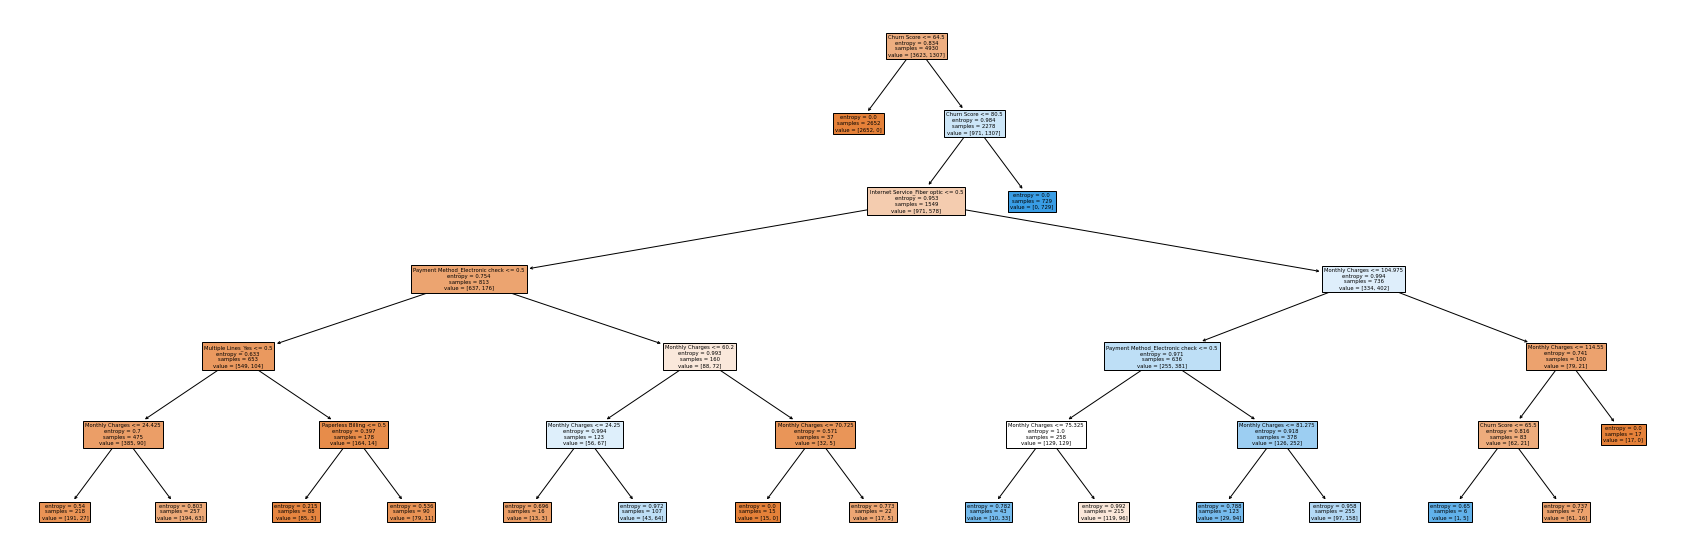

In [468]:
#Afficher l'arbre de décision de final_model et le compararer à celui de la première partie.
from sklearn.tree import plot_tree
plt.figure(figsize=(30,10))
plot_tree(final_model, feature_names= names, filled=True)
plt.savefig("tree.png")
plt.show()


In [469]:
final_model.feature_importances_

array([0.89906222, 0.04490578, 0.01822876, 0.03328534, 0.00124032,
       0.        , 0.        , 0.        , 0.00327758, 0.        ])

In [470]:
from sklearn.tree import export_text
print(export_text(final_model, feature_names=names))

|--- Churn Score <= 64.50
|   |--- class: 0
|--- Churn Score >  64.50
|   |--- Churn Score <= 80.50
|   |   |--- Internet Service_Fiber optic <= 0.50
|   |   |   |--- Payment Method_Electronic check <= 0.50
|   |   |   |   |--- Multiple Lines_Yes <= 0.50
|   |   |   |   |   |--- Monthly Charges <= 24.43
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Monthly Charges >  24.43
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Multiple Lines_Yes >  0.50
|   |   |   |   |   |--- Paperless Billing <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Paperless Billing >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Payment Method_Electronic check >  0.50
|   |   |   |   |--- Monthly Charges <= 60.20
|   |   |   |   |   |--- Monthly Charges <= 24.25
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Monthly Charges >  24.25
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Monthly Charges >  60.20
|   |   |   |   | 

In [471]:
#Predictive models
#Define predictors and target values
target = 'Churn Value'
predictors = ['Gender','Senior Citizen','Partner','Dependents','Paperless Billing','Phone Service']

In [472]:
#Split data in train, test and validation set
#Let's define train, validation and test sets.

train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [473]:
#RandomForestClassifier
#Define model parameters
#Let's set the parameters for the model.

#Let's run a model using the training set for training. Then, we will use the validation set for validation.

#We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) [4]. Number of estimators is set to 100 and number of parallel jobs is set to 4.

#We start by initializing the RandomForestClassifie
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [474]:
df = df.fillna(value=0)


In [475]:
#Let's train the RandonForestClassifier using the train_df data and fit function.
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [476]:
preds = clf.predict(valid_df[predictors])

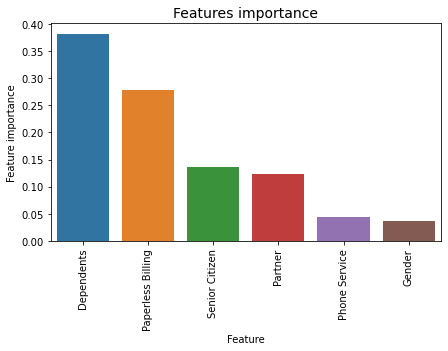

In [477]:
#Let's also visualize the features importance.

#Features importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


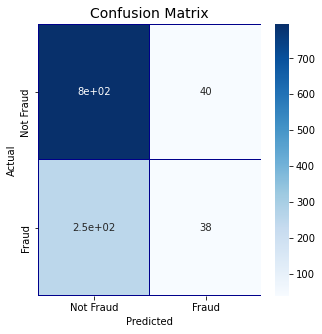

In [478]:
#Confusion matrix
#Let's show a confusion matrix for the results we obtained.
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [479]:
#Let's calculate the ROC-AUC score [4].
#Area under curve
roc_auc_score(valid_df[target].values, preds)

0.5413686512438547

In [480]:
#AdaBoostClassifier
#AdaBoostClassifier stands for Adaptive Boosting Classifier .

#Prepare the model
#Let's set the parameters for the model and initialize the model.
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [481]:
#Fit the model
#Let's fit the model.
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [482]:
#Predict the target values
#Let's now predict the target values for the valid_df data, using predict function.

preds = clf.predict(valid_df[predictors])

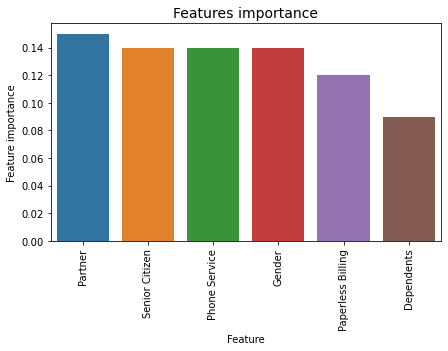

In [483]:
#Features importance
#Let's see also the features importance.

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

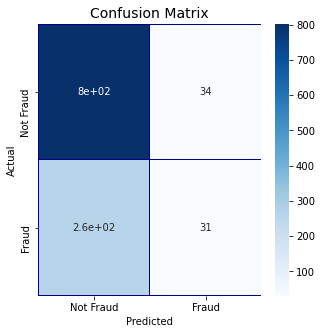

In [484]:
#Confusion matrix
#Let's visualize the confusion matrix.

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [485]:
#Let's calculate also the ROC-AUC.
#Area under curve
roc_auc_score(valid_df[target].values, preds)

0.5329296765813315

In [486]:
#CatBoostClassifier
#CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data [6].

#Prepare the model
#Let's set the parameters for the model and initialize the model.

clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [487]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 47.2ms	remaining: 23.5s
50:	total: 152ms	remaining: 1.34s
100:	total: 265ms	remaining: 1.05s
150:	total: 372ms	remaining: 861ms
200:	total: 488ms	remaining: 725ms
250:	total: 595ms	remaining: 591ms
300:	total: 700ms	remaining: 463ms
350:	total: 801ms	remaining: 340ms
400:	total: 902ms	remaining: 223ms
450:	total: 998ms	remaining: 108ms
499:	total: 1.11s	remaining: 0us


In [488]:
#Predict the target values
#Let's now predict the target values for the val_df data, using predict function.

preds = clf.predict(valid_df[predictors])

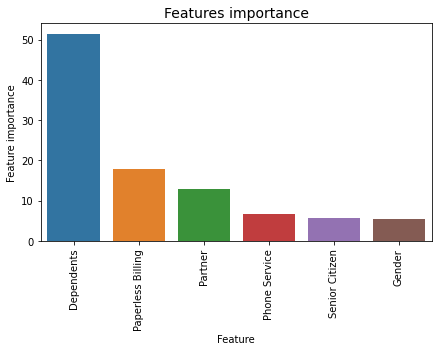

In [489]:
#Features importance
#Let's see also the features importance.
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


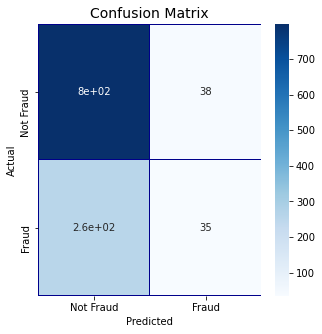

In [490]:
#Confusion matrix
#Let's visualize the confusion matrix.

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [491]:
#Let's calculate also the ROC-AUC.
#Area under curve
roc_auc_score(valid_df[target].values, preds)

0.5374101843174008

In [492]:
#The ROC-AUC score obtained with CatBoostClassifier is 0.86.

#XGBoost
#XGBoost is a gradient boosting algorithm [7].
#Let's prepare the model.
#Prepare the model
#We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [493]:
#Train the model
#Let's train the model.

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[17:54:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65176	valid-auc:0.63984
[50]	train-auc:0.70940	valid-auc:0.69454
[57]	train-auc:0.70940	valid-auc:0.69454


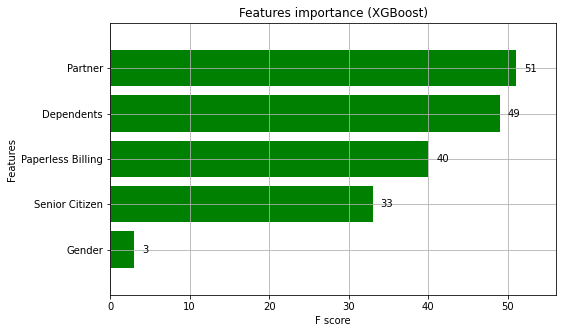

In [494]:
#Plot variable importance
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [495]:
#Predict test set
#We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

preds = model.predict(dtest)

In [496]:
#Area under curve
#Let's calculate ROC-AUC.

roc_auc_score(test_df[target].values, preds)

0.7276637275857974

In [497]:
#LightGBM
#Let's continue with another gradient boosting algorithm, LightGBM [8] [9].

#Define model parameters
#Let's set the parameters for the model. We will use these parameters only for the first lgb model.
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [498]:
#Prepare the model
#Let's prepare the model, creating the Datasets data structures from the train and validation sets.

dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [499]:
#Run the model
#Let's run the model, using the train function.
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.711038	valid's auc: 0.69417
[100]	train's auc: 0.71258	valid's auc: 0.696633
[150]	train's auc: 0.713986	valid's auc: 0.695739
[200]	train's auc: 0.714085	valid's auc: 0.695459
Early stopping, best iteration is:
[113]	train's auc: 0.711981	valid's auc: 0.698369


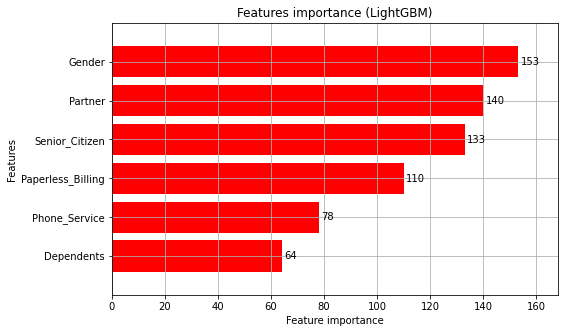

In [500]:
#Let's plot variable importance.

fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [501]:
#let's predict now the target for the test data.

#Predict test data
preds = model.predict(test_df[predictors])

In [502]:
#Area under curve
#Let's calculate the ROC-AUC score for the prediction.

roc_auc_score(test_df[target].values, preds)

0.7233268515219885

In [503]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.685667	valid_1's auc: 0.715873
Early stopping, best iteration is:
[1]	training's auc: 0.685667	valid_1's auc: 0.715873
Fold  1 AUC : 0.715873
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.69348	valid_1's auc: 0.684715
Early stopping, best iteration is:
[1]	training's auc: 0.69348	valid_1's auc: 0.684715
Fold  2 AUC : 0.684715
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.694973	valid_1's auc: 0.688468
Early stopping, best iteration is:
[1]	training's auc: 0.694973	valid_1's auc: 0.688468
Fold 

In [504]:
#The AUC score for the prediction from the test data was 0.93.

#We prepare the test prediction, from the averaged predictions for test over the 5 folds.

pred = test_preds